In [145]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scout import utils
from scout import io

In [146]:
working_dir = '/data/datasets/organoid_phenotyping/analysis/zika_vs_mock/'
os.listdir(working_dir)

['example_roi_Artifacts.pdf',
 'example_roi_Adjacent.pdf',
 'zika_vs_mock_average_profiles_Adjacent.pdf',
 'ventricle_size_vs_sox2_freq.pdf',
 'TBR1_microenvironment_Mock_vs_Zika_ROIs.pdf',
 'example_roi_Surface-DN.pdf',
 'zika_vs_mock_average_profiles_Surface-DN.pdf',
 'zika_vs_mock_average_profiles_Surface-TBR1.pdf',
 'zika_vs_mock_average_profiles_Artifacts.pdf',
 'cyto_zika_umap.pdf',
 'example_roi_DN.pdf',
 'cyto_profiles_combined.npy',
 'Zika',
 'average_profile_DN.pdf',
 'analysis.csv',
 'cyto_clusters_umap.pdf',
 'umap_zika_vs_mock.pdf',
 'average_profile_Artifacts.pdf',
 'volcano_plot_zika.pdf',
 'average_profile_Surface-DN.pdf',
 'model_zikv.umap',
 'cyto_profiles_combined_samples.npy',
 'clustermap_zika_hits.pdf',
 'example_roi_Surface-TBR1.pdf',
 'Zika_mock',
 'cyto_labels_combined.npy',
 'mean_SOX2_ventricle_distance.pdf',
 'zika_vs_mock_average_profiles_DN.pdf',
 'average_profile_Surface-TBR1.pdf',
 'zikv_with_FC.xlsx',
 'average_profile_Adjacent.pdf',
 'combined_features

In [147]:
analysis = pd.read_csv(os.path.join(working_dir, 'analysis.csv'), index_col=0)
analysis.head()

,type
path,
20190625_14_48_13_AA_ef24-zika1_488LP15_561LP140_642LP50,Zika
20190625_15_22_42_AA_ef24-zika2_488LP20_561LP140_642LP50,Zika
20190625_16_04_10_AA_ef24-zika3_488LP18_561LP140_642LP50,Zika
20190625_16_22_54_AA_ef24-zika4_488LP18_561LP140_642LP50,Zika
20190625_16_31_09_AA_ef24-zika5_488LP14_561LP140_642LP50,Zika


In [148]:
analysis['folder'] = analysis['type']

# Swap Zika 1 for Ctrl 1, and Zika 5 for Ctrl 5
z1_idx = ['zika1' in p for p in analysis.index].index(True)
z5_idx = ['zika5' in p for p in analysis.index].index(True)
c1_idx = ['ctrl1' in p for p in analysis.index].index(True)
c5_idx = ['ctrl5' in p for p in analysis.index].index(True)

analysis['type'].iloc[z1_idx] = 'Zika_mock'
analysis['type'].iloc[z5_idx] = 'Zika_mock'
analysis['type'].iloc[c1_idx] = 'Zika'
analysis['type'].iloc[c5_idx] = 'Zika'

analysis

,type,folder
path,,
20190625_14_48_13_AA_ef24-zika1_488LP15_561LP140_642LP50,Zika_mock,Zika
20190625_15_22_42_AA_ef24-zika2_488LP20_561LP140_642LP50,Zika,Zika
20190625_16_04_10_AA_ef24-zika3_488LP18_561LP140_642LP50,Zika,Zika
20190625_16_22_54_AA_ef24-zika4_488LP18_561LP140_642LP50,Zika,Zika
20190625_16_31_09_AA_ef24-zika5_488LP14_561LP140_642LP50,Zika_mock,Zika
20190625_17_15_27_AA_ef24-zika6_488LP25_561LP140_642LP50,Zika,Zika
20190625_12_18_15_AA_ef24-ctrl1_488LP14_561LP140_642LP50,Zika,Zika_mock
20190625_12_38_41_AA_ef24-ctrl2_488LP13_561LP140_642LP50,Zika_mock,Zika_mock
20190625_13_00_22_AA_ef24-ctrl3_488LP15_561LP140_642LP50,Zika_mock,Zika_mock


# Pool proximities across Zikas to get more TBR1+ cells

In [149]:
proximities_mock = np.concatenate([np.load(os.path.join(working_dir, f, p, 'dataset/niche_proximities.npy')) for f, p, t in zip(analysis['folder'], analysis.index, analysis['type']) if t == 'Zika_mock'])
proximities_zika = np.concatenate([np.load(os.path.join(working_dir, f, p, 'dataset/niche_proximities.npy')) for f, p, t in zip(analysis['folder'], analysis.index, analysis['type']) if t == 'Zika'])

labels_mock = np.concatenate([np.load(os.path.join(working_dir, f, p, 'dataset/nuclei_gating.npy')) for f, p, t in zip(analysis['folder'], analysis.index, analysis['type']) if t == 'Zika_mock'])
labels_zika = np.concatenate([np.load(os.path.join(working_dir, f, p, 'dataset/nuclei_gating.npy')) for f, p, t in zip(analysis['folder'], analysis.index, analysis['type']) if t == 'Zika'])

proximities_mock.shape, proximities_zika.shape, labels_mock.shape, labels_zika.shape

((14116931, 2), (3717162, 2), (14116931, 2), (3717162, 2))

Get all strictly TBR1+ proximities

In [150]:
idx_tbr1_mock = np.where(np.logical_and(labels_mock[:, 1] == 1, labels_mock[:, 0] == 0))[0]
idx_tbr1_zika = np.where(np.logical_and(labels_zika[:, 1] == 1, labels_zika[:, 0] == 0))[0]

prox_tbr1_mock = proximities_mock[idx_tbr1_mock]
prox_tbr1_zika = proximities_zika[idx_tbr1_zika]

prox_tbr1_mock.shape, prox_tbr1_zika.shape

((1782402, 2), (70048, 2))

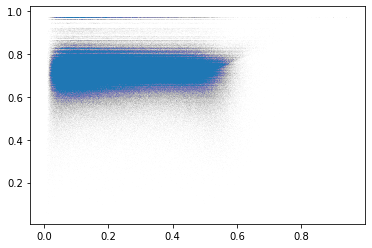

In [28]:
plt.scatter(prox_tbr1_mock[:, 0], prox_tbr1_mock[:, 1], s=1, alpha=0.002)
plt.show()

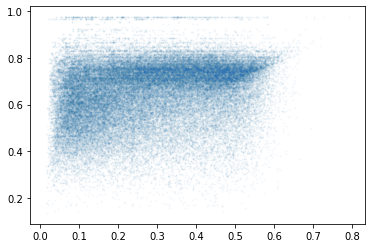

In [31]:
plt.scatter(prox_tbr1_zika[:, 0], prox_tbr1_zika[:, 1], s=1, alpha=0.04)
plt.show()

In [151]:
n_cells = 10_000

idx_sample_mock = np.random.choice(np.arange(len(prox_tbr1_mock)), n_cells, replace=False)
idx_sample_zika = np.random.choice(np.arange(len(prox_tbr1_zika)), n_cells, replace=False)

prox_tbr1_mock_sample = prox_tbr1_mock[idx_sample_mock]
prox_tbr1_zika_sample = prox_tbr1_zika[idx_sample_zika]

prox_tbr1_mock_sample.shape, prox_tbr1_zika_sample.shape

((10000, 2), (10000, 2))

In [152]:
from scipy.stats import gaussian_kde
from scipy.interpolate import RegularGridInterpolator

In [153]:
grid_size = 100

X, Y = np.mgrid[0:1:100j, 0:1:100j]
positions = np.vstack([X.ravel(), Y.ravel()])

kernel_mock = gaussian_kde(prox_tbr1_mock_sample.T)
kernel_zika = gaussian_kde(prox_tbr1_zika_sample.T)

Z_mock = np.reshape(kernel_mock(positions).T, X.shape)
Z_zika = np.reshape(kernel_zika(positions).T, X.shape)
Z_mock.shape, Z_zika.shape

((100, 100), (100, 100))

In [154]:
f_mock = RegularGridInterpolator(2*(np.linspace(0, 1, 100),), Z_mock)
f_zika = RegularGridInterpolator(2*(np.linspace(0, 1, 100),), Z_zika)

z_mock = f_mock(prox_tbr1_mock)
z_zika = f_zika(prox_tbr1_zika)

z_mock.shape, z_zika.shape

((1782402,), (70048,))

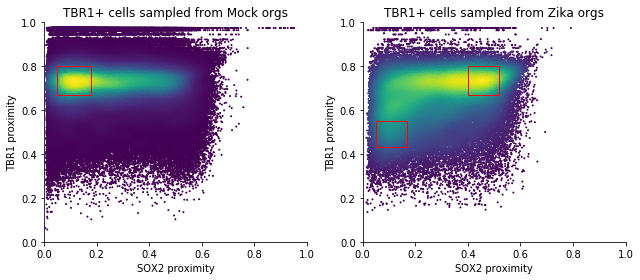

In [155]:
start_mock = np.asarray([0.05, 0.67])
stop_mock = np.asarray([0.18, 0.8])

start1_zika = np.asarray([0.05, 0.43])
stop1_zika = np.asarray([0.17, 0.55])

start2_zika = np.asarray([0.4, 0.67])
stop2_zika = np.asarray([0.52, 0.8])

plt.figure(figsize=(9, 4))

ax1 = plt.subplot(1, 2, 1)
plt.scatter(prox_tbr1_mock[:, 0], prox_tbr1_mock[:, 1], s=1, c=z_mock, edgecolor=None)
rect = Rectangle(start_mock, stop_mock[0]-start_mock[0], stop_mock[1]-start_mock[1], edgecolor='r', linewidth=1, fill=False)
ax1.add_patch(rect)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title(f'TBR1+ cells sampled from Mock orgs')
plt.xlabel('SOX2 proximity')
plt.ylabel('TBR1 proximity')

ax2 = plt.subplot(1, 2, 2)
plt.scatter(prox_tbr1_zika[:, 0], prox_tbr1_zika[:, 1], s=1, c=z_zika, edgecolor=None)
rect = Rectangle(start1_zika, stop1_zika[0]-start1_zika[0], stop1_zika[1]-start1_zika[1], edgecolor='r', linewidth=1, fill=False)
ax2.add_patch(rect)
rect = Rectangle(start2_zika, stop2_zika[0]-start2_zika[0], stop2_zika[1]-start2_zika[1], edgecolor='r', linewidth=1, fill=False)
ax2.add_patch(rect)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title(f'TBR1+ cells sampled from Zika orgs')
plt.xlabel('SOX2 proximity')
plt.ylabel('TBR1 proximity')

plt.tight_layout()
sns.despine()

plt.savefig(os.path.join(working_dir, 'TBR1_microenvironment_Mock_vs_Zika_gates.png'), bbox_inches='tight')

plt.show()

# Example images from one Mock and one Zika organoid

Get centroids, labels, and proximities from an example Zika and Mock organoid

In [97]:
mock_orgs = analysis.where(analysis['type'] == 'Zika_mock').dropna()
zika_orgs = analysis.where(analysis['type'] == 'Zika').dropna()

len(mock_orgs), len(zika_orgs)

(10, 6)

In [127]:
mock_idx = 1
zika_idx = 3

mock_org = mock_orgs.iloc[mock_idx]
zika_org = zika_orgs.iloc[zika_idx]

mock_path = os.path.join(working_dir, mock_org['folder'], mock_orgs.index[mock_idx])
zika_path = os.path.join(working_dir, zika_org['folder'], zika_orgs.index[zika_idx])
mock_path, zika_path

('/data/datasets/organoid_phenotyping/analysis/zika_vs_mock/Zika/20190625_16_31_09_AA_ef24-zika5_488LP14_561LP140_642LP50',
 '/data/datasets/organoid_phenotyping/analysis/zika_vs_mock/Zika/20190625_17_15_27_AA_ef24-zika6_488LP25_561LP140_642LP50')

In [128]:
centroids_mock = np.load(os.path.join(mock_path, 'dataset/centroids.npy'))
centroids_zika = np.load(os.path.join(zika_path, 'dataset/centroids.npy'))

labels_mock = np.load(os.path.join(mock_path, 'dataset/nuclei_gating.npy'))
labels_zika = np.load(os.path.join(zika_path, 'dataset/nuclei_gating.npy'))

proximities_mock = np.load(os.path.join(mock_path, 'dataset/niche_proximities.npy'))
proximities_zika = np.load(os.path.join(zika_path, 'dataset/niche_proximities.npy'))

centroids_mock.shape, centroids_zika.shape

((801701, 3), (316765, 3))

Extract all TBR1+ proximities

In [129]:
# idx_tbr1_mock = np.where(labels_mock[:, 1] == 1)[0]
# idx_tbr1_zika = np.where(labels_zika[:, 1] == 1)[0]

idx_tbr1_mock = np.where(np.logical_and(labels_mock[:, 1] == 1, labels_mock[:, 0] == 0))[0]
idx_tbr1_zika = np.where(np.logical_and(labels_zika[:, 1] == 1, labels_zika[:, 0] == 0))[0]

prox_tbr1_mock = proximities_mock[idx_tbr1_mock]
prox_tbr1_zika = proximities_zika[idx_tbr1_zika]

prox_tbr1_mock.shape, prox_tbr1_zika.shape

((126545, 2), (6044, 2))

In [130]:
%matplotlib inline

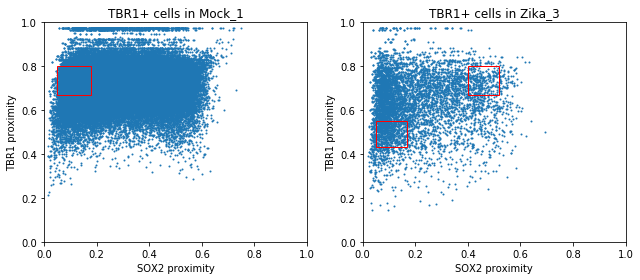

In [131]:
plt.figure(figsize=(9, 4))
ax1 = plt.subplot(1, 2, 1)
plt.scatter(prox_tbr1_mock[:, 0], prox_tbr1_mock[:, 1], s=1)
rect = Rectangle(start_mock, stop_mock[0]-start_mock[0], stop_mock[1]-start_mock[1], edgecolor='r', linewidth=1, fill=False)
ax1.add_patch(rect)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title(f'TBR1+ cells in Mock_{mock_idx}')
plt.xlabel('SOX2 proximity')
plt.ylabel('TBR1 proximity')
ax2 = plt.subplot(1, 2, 2)
plt.scatter(prox_tbr1_zika[:, 0], prox_tbr1_zika[:, 1], s=1)
rect = Rectangle(start1_zika, stop1_zika[0]-start1_zika[0], stop1_zika[1]-start1_zika[1], edgecolor='r', linewidth=1, fill=False)
ax2.add_patch(rect)
rect = Rectangle(start2_zika, stop2_zika[0]-start2_zika[0], stop2_zika[1]-start2_zika[1], edgecolor='r', linewidth=1, fill=False)
ax2.add_patch(rect)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title(f'TBR1+ cells in Zika_{zika_idx}')
plt.xlabel('SOX2 proximity')
plt.ylabel('TBR1 proximity')
plt.tight_layout()
plt.show()

In [132]:
def apply_gate(start, stop, prox):
    cond0 = np.logical_and(prox[:, 0] > start[0], prox[:, 0] < stop[0])
    cond1 = np.logical_and(prox[:, 1] > start[1], prox[:, 1] < stop[1])
    idx = np.where(np.logical_and(cond0, cond1))[0]
    return prox[idx], idx

In [133]:
prox_tbr1_mock_gate, idx_gate_mock = apply_gate(start_mock, stop_mock, prox_tbr1_mock)
prox_tbr1_zika_gate1, idx_gate1_zika = apply_gate(start1_zika, stop1_zika, prox_tbr1_zika)
prox_tbr1_zika_gate2, idx_gate2_zika = apply_gate(start2_zika, stop2_zika, prox_tbr1_zika)

prox_tbr1_mock_gate.shape, prox_tbr1_zika_gate1.shape, prox_tbr1_zika_gate2.shape

((16167, 2), (661, 2), (267, 2))

In [134]:
syto_mock = io.open(os.path.join(mock_path, 'dataset/syto.zarr'))
sox2_mock = io.open(os.path.join(mock_path, 'dataset/sox2.zarr'))
tbr1_mock = io.open(os.path.join(mock_path, 'dataset/tbr1.zarr'))

syto_zika = io.open(os.path.join(zika_path, 'dataset/syto.zarr'))
sox2_zika = io.open(os.path.join(zika_path, 'dataset/sox2.zarr'))
tbr1_zika = io.open(os.path.join(zika_path, 'dataset/tbr1.zarr'))

syto_mock.shape, syto_zika.shape

((600, 3703, 3703), (600, 2048, 3703))

In [135]:
%matplotlib inline

In [136]:
centers_mock = centroids_mock[idx_tbr1_mock[idx_gate_mock]]
centers_zika1 = centroids_zika[idx_tbr1_zika[idx_gate1_zika]]
centers_zika2 = centroids_zika[idx_tbr1_zika[idx_gate2_zika]]

centers_mock.shape, centers_zika1.shape, centers_zika2.shape

((16167, 3), (661, 3), (267, 3))

In [143]:
working_dir

'/data/datasets/organoid_phenotyping/analysis/zika_vs_mock/'

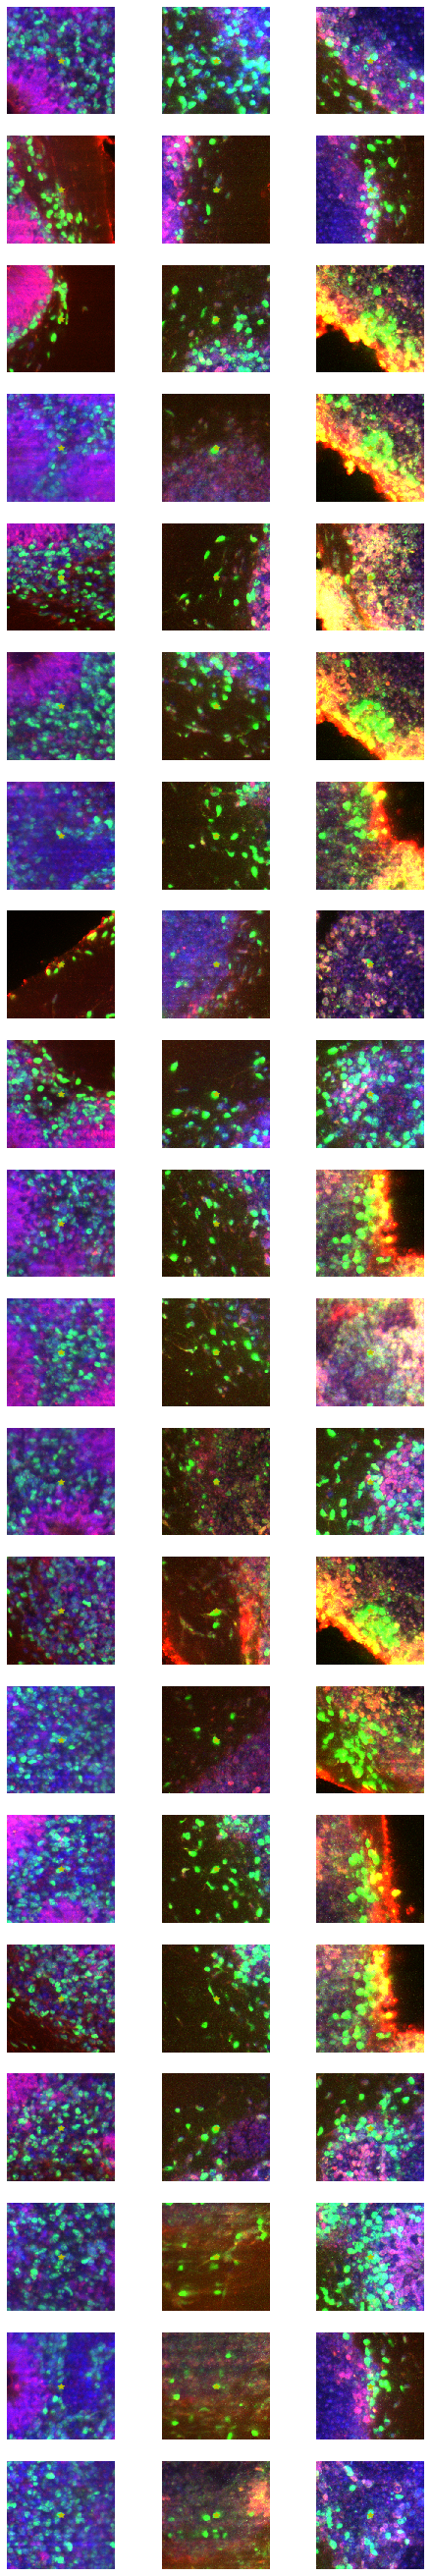

In [144]:
n = 20
width = 256

plt.figure(figsize=(8, 48))

np.random.seed(321)

for i in range(n):
    
    c_mock = centers_mock[np.random.choice(len(centers_mock))]
    c_zika1 = centers_zika1[np.random.choice(len(centers_zika1))]
    c_zika2 = centers_zika2[np.random.choice(len(centers_zika2))]
    cs = [c_mock, c_zika1, c_zika2]
    
    for k, center in enumerate(cs):
        roi_start = np.asarray([center[0]-1, center[1] - width//2, center[2] - width//2])
        roi_stop = np.asarray([center[0]+1, center[1] + width//2, center[2] + width//2])
        roi_start = np.maximum(roi_start, np.zeros(3)).astype(np.int)
        roi_stop = np.minimum(roi_stop, np.asarray(syto_mock.shape)).astype(np.int)
        if k == 0:
            syto_roi = utils.extract_box(syto_mock, roi_start, roi_stop) 
            sox2_roi = utils.extract_box(sox2_mock, roi_start, roi_stop) * 1.5
            tbr1_roi = utils.extract_box(tbr1_mock, roi_start, roi_stop)
        else:
            syto_roi = utils.extract_box(syto_zika, roi_start, roi_stop) 
            sox2_roi = utils.extract_box(sox2_zika, roi_start, roi_stop) * 2.5
            tbr1_roi = utils.extract_box(tbr1_zika, roi_start, roi_stop)
        roi = np.dstack([sox2_roi.max(axis=0), tbr1_roi.max(axis=0), syto_roi.max(axis=0)])
        roi = np.clip(roi, 0, 1)
        
        plt.subplot(n, 3, k+1 + 3*i)
        plt.imshow(roi)
        plt.plot([width//2], [width//2], 'y*')
#         plt.title(str(center))
        plt.axis('off')
plt.savefig(os.path.join(working_dir, 'TBR1_microenvironment_Mock_vs_Zika_ROIs.pdf'), bbox_inches='tight')
plt.show()

Random sample catches a lot of non-specific stuff, should sort by sampled TBR1 fluorescence

In [ ]:
from scout import plot

In [ ]:
%matplotlib notebook

In [ ]:
plot.zprojection(syto_mock, centers=centroids_mock, zlim=[300, 305])